### Experiment Protocols

Subjects rested on a tilt table with foot support and subsequently underwent a series of six changes in posture: 
- Two stand-ups, (= 6 min)
- Two rapid HUTs (75◦ HUT over 2 secs), and (= 6 min)
- Two slow HUTs (75◦ HUT over 50 secs) (= 6 min)
- Each lasting for three minutes and separated by five minutes in the resting supine position.
- The sequence of six interventions was randomized for each subject.
- At the conclusion of the final intervention, the subject was returned to the horizontal position for a final five minutes of   supine baseline recording.

For six postural changes:
- Rest -> PC -> Rest -> PC -> Rest -> PC -> Rest -> PC -> Rest -> PC -> Rest -> PC -> Rest ( atleast 35 + 18 = 53 min of data)


- The RR interval data is cleaned by removing outliers
- No interpolation

In [1]:
# import libraries

%matplotlib inline
import math
import numpy as np
import pandas as pd

from Laguerre_UpdatedIndices import phi_j, l_j, lagl_j # call laguerre related functions from .py file

import scipy.stats as stats
from scipy.signal import find_peaks

import matplotlib.pyplot as plt
import seaborn as sns

# ECG processing libraries
import scipy.signal 
import peakutils
import heartpy as hp
import wfdb
from wfdb import processing


#### Value of constants

In [2]:
#Constants for Laguerre calculations 
alpha = .2
J = 8
N1 = 2
N2 = 7

#window size
W_n = 90

# RLS model
num_parameters = 10
forgetting_factor = .98

# Values taken from related paper
coeff_S = [39.2343, 10.1963, -5.9242] 
coeff_P = [28.4875, -17.3627, 5.8798, 12.0628, 5.6408, -7.0664, -5.6779, -3.9474]


#### Define functions

In [3]:
# define function to identify outliers using Interquartile menthod
def find_outliers(df, thresh):
    q1 = np.quantile(df, 0.25)
    q3 = np.quantile(df, 0.75)
    IQR=q3-q1
    outliers = df[(df < (q1 - thresh*IQR)) | (df > (q3 + thresh*IQR))]
    return outliers

In [4]:
def normalize(x):
    x = x - np.mean(x)
    return x/np.std(x)

#### Read one ECG recording in wfdb format

In [5]:
# Plot the signals, and show the data.
record = wfdb.rdrecord('changes-in-postureData/12726') 
#wfdb.plot_wfdb(record=record, title='Record 12726 from PhysioNet Postural Data', figsize=(12,10)) 
display(record.__dict__)

{'record_name': '12726',
 'n_sig': 3,
 'fs': 250,
 'counter_freq': 24000.0,
 'base_counter': None,
 'sig_len': 825000,
 'base_time': datetime.time(15, 8, 24),
 'base_date': None,
 'comments': ['<age>: 28  <sex>: M  <Height>: 170  <Weight>: 64',
  'Produced by xform from record 12726_orig, beginning at 0:0'],
 'sig_name': ['ABP', 'ECG', 'Angle'],
 'p_signal': array([[ 6.24804749e+01, -1.98291120e+00, -4.57587371e-02],
        [ 6.21055920e+01, -1.98962466e+00, -4.57587371e-02],
        [ 6.14807873e+01, -1.97070491e+00, -4.57587371e-02],
        ...,
        [ 8.12246173e-01,  6.10314312e-04, -1.60155580e-01],
        [ 8.12246173e-01,  6.10314312e-04, -1.60155580e-01],
        [ 8.12246173e-01,  6.10314312e-04, -1.60155580e-01]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['12726.dat', '12726.dat', '12726.dat'],
 'fmt': ['16', '16', '16'],
 'samps_per_frame': [1, 1, 1],
 'skew': [None, None, None],
 'byte_offset': [None, None, None],
 'adc_gain': [64.02

In [6]:
#Convert record into dataframe whose index is TimedeltaIndex
record_df = record.to_dataframe()
record_df.head()

,ABP,ECG,Angle
0 days 00:00:00,62.480475,-1.982911,-0.045759
0 days 00:00:00.004000,62.105592,-1.989625,-0.045759
0 days 00:00:00.008000,61.480787,-1.970705,-0.045759
0 days 00:00:00.012000,61.168385,-1.966433,-0.045759
0 days 00:00:00.016000,60.855983,-1.979860,-0.045759


In [7]:
# ECG data is saved in an array
# ecg_data = record.p_signal[:,1]
ecg_df = pd.DataFrame(record_df['ECG'])
angle_df = pd.DataFrame(record_df['Angle'])


#### Working with ECG data

In [8]:
# ecg_data
print(ecg_df.head())
print(len(ecg_df))

                             ECG
0 days 00:00:00        -1.982911
0 days 00:00:00.004000 -1.989625
0 days 00:00:00.008000 -1.970705
0 days 00:00:00.012000 -1.966433
0 days 00:00:00.016000 -1.979860
825000


In [9]:
angle_df.head()

,Angle
0 days 00:00:00,-0.045759
0 days 00:00:00.004000,-0.045759
0 days 00:00:00.008000,-0.045759
0 days 00:00:00.012000,-0.045759
0 days 00:00:00.016000,-0.045759


In [10]:
# using heartpy.process, wd = working_data dict in which results are stored, measures(m): measures dict in which results are stored
wd_band, m_band = hp.process(ecg_df['ECG'], sample_rate = record.fs)


In [11]:
# number of RR peaks
len(wd_band['peaklist'])

3800

#### Find rr interval using 'peaklist' from 'wd'

In [12]:
t = np.arange(0, len(ecg_df))/250

# Finding RR interval
RR = np.diff(t[wd_band["peaklist"]])
print(len(RR))

3799


In [13]:
RR

array([0.988, 1.008, 0.944, ..., 0.996, 1.092, 0.812])

In [14]:
HR = 60/RR

print(HR, len(HR))

[60.72874494 59.52380952 63.55932203 ... 60.24096386 54.94505495
 73.89162562] 3799


In [15]:
print('max HR is', max(HR), ' and min HR is', min(HR))

max HR is 15000.000000354703  and min HR is 7.763975155279551


#### Working with angle_data -- Finding angle value at the peaks

In [16]:
peak_angle = angle_df['Angle'][wd_band['peaklist']].reset_index().drop(columns=['index'])
print(peak_angle)
print(type(peak_angle))

         Angle
0    -0.045759
1    -0.045759
2    -0.045759
3    -0.045759
4    -0.045759
...        ...
3795  0.068638
3796  0.068638
3797  0.068638
3798  0.068638
3799  0.068638

[3800 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>


#### Remove outliers from the RR_interval data

In [17]:
time_df = t[wd_band["peaklist"]] #find time points of R-peaks

RR_df = pd.DataFrame(RR, time_df[1:]).reset_index().rename(columns={'index':'beats', 0:'RR'})
RR_df['angle_peaks'] = peak_angle
#RR_df['timestamp_peaks'] = timestamp_peaks
RR_df

,beats,RR,angle_peaks
0,1.232,0.988,-0.045759
1,2.240,1.008,-0.045759
2,3.184,0.944,-0.045759
3,4.168,0.984,-0.045759
4,5.152,0.984,-0.045759
...,...,...,...
3794,3247.488,1.020,0.068638
3795,3248.528,1.040,0.068638
3796,3249.524,0.996,0.068638
3797,3250.616,1.092,0.068638


In [18]:
# Remove outliers from RR_df
outliers = find_outliers(RR_df['RR'], 1.5) # multiplier=1.5
print(outliers, len (outliers))
print('....................')
RR_clean = RR_df.drop(outliers.index).reset_index().drop(columns='index') 
print(RR_clean)



423     0.008
424     1.700
668     0.008
673     3.908
688     0.236
        ...  
3534    1.516
3620    0.008
3622    1.500
3711    0.008
3712    1.656
Name: RR, Length: 232, dtype: float64 232
....................
         beats     RR  angle_peaks
0        1.232  0.988    -0.045759
1        2.240  1.008    -0.045759
2        3.184  0.944    -0.045759
3        4.168  0.984    -0.045759
4        5.152  0.984    -0.045759
...        ...    ...          ...
3562  3247.488  1.020     0.068638
3563  3248.528  1.040     0.068638
3564  3249.524  0.996     0.068638
3565  3250.616  1.092     0.068638
3566  3251.428  0.812     0.068638

[3567 rows x 3 columns]


#### COmparison of RR interval data before and after removing the outlier

Text(0.5, 1.0, 'histogram of RR intervals after removing outliers')

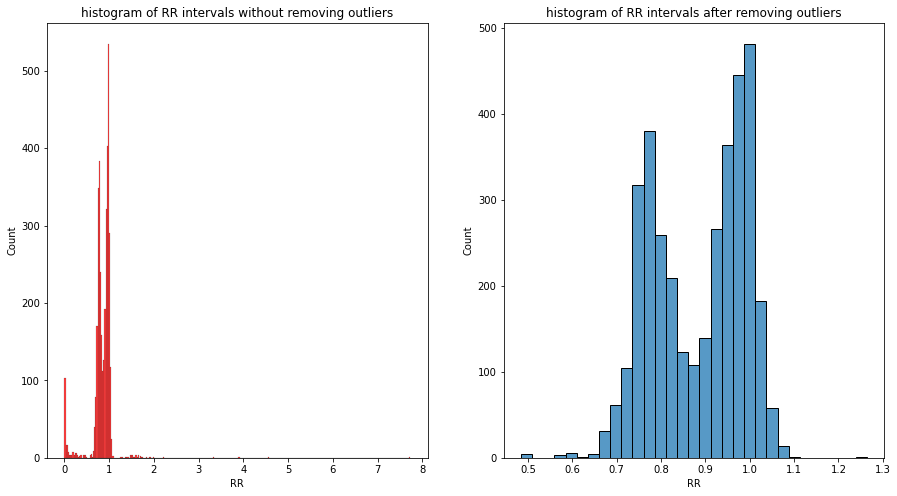

In [19]:
fig, ax = plt.subplots(1,2, figsize=(15, 8))
sns.histplot(RR_df['RR'], ax=ax[0], color='red')
ax[0].set_title('histogram of RR intervals without removing outliers')

sns.histplot(RR_clean['RR'], ax=ax[1])
ax[1].set_title('histogram of RR intervals after removing outliers')

#### Comparison of RR intervals with angle- before and after removing outliers

Text(0.5, 0, 'time (in min)')

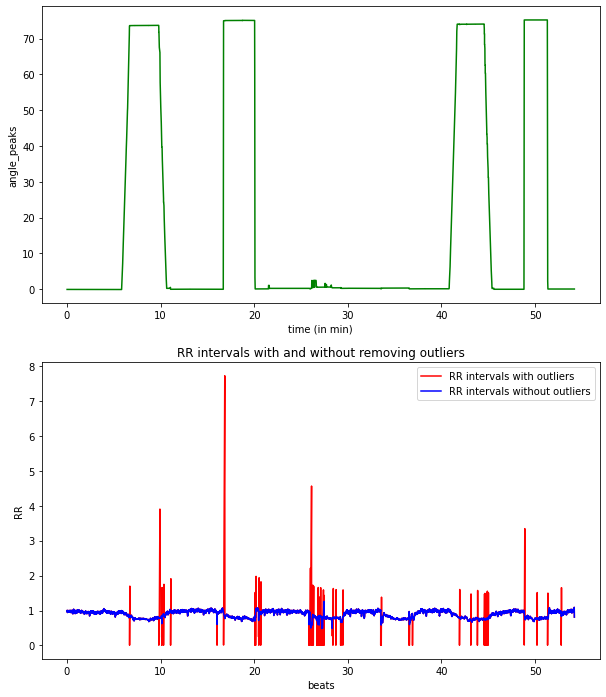

In [20]:
fig, ax = plt.subplots(2,1, figsize=(10, 12))


sns.lineplot(data = RR_df, x = RR_df['beats']/60, y='angle_peaks', ax=ax[0], color='green')
sns.lineplot(data = RR_df, x = RR_df['beats']/60, y='RR', ax=ax[1], color='red', label='RR intervals with outliers')
sns.lineplot(data = RR_clean, x = RR_clean['beats']/60, y='RR', ax=ax[1], color='blue', label='RR intervals without outliers')

ax[1].set_title('RR intervals with and without removing outliers')
ax[0].set_xlabel('time (in min)')

# ax[2].set_title('RR intervals after removing outliers')

#### Rolling mean of clean RR interval data with window size W_n

In [21]:
mu_rr=[]
for i in range(W_n, len(RR_clean)+1):
    mu_rr.append(np.mean(RR_clean['RR'][i-W_n:i]))

Text(0.5, 0, 'time(min)')

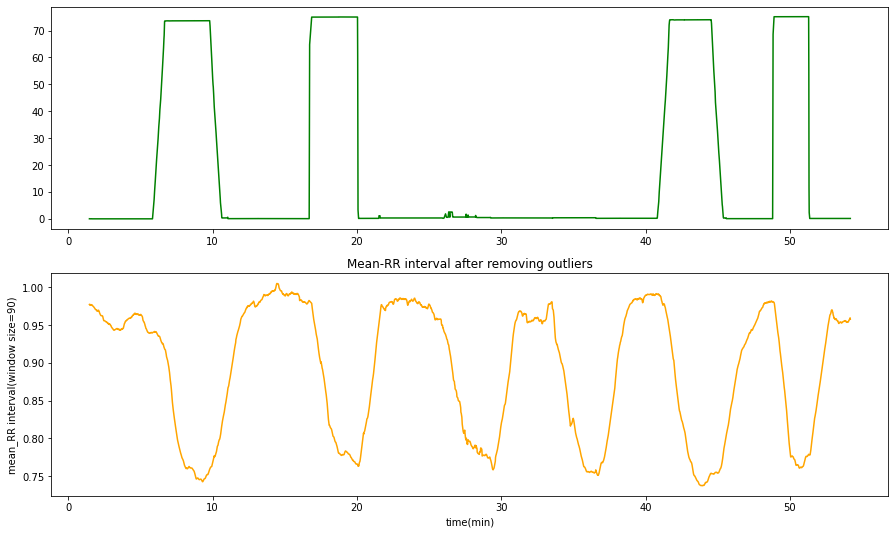

In [22]:
fig, ax = plt.subplots(2,1,figsize = (15,9))
ax[0].plot(RR_clean['beats'][W_n-1:]/60, RR_clean['angle_peaks'][W_n-1:], c='green')
ax[1].plot(RR_clean['beats'][W_n-1:]/60, mu_rr, c='orange')
ax[1].set_ylabel('mean_RR interval(window size=90)')
ax[1].set_title('Mean-RR interval after removing outliers')
ax[1].set_xlabel('time(min)')

#### Calculating Laguerre function of order j with time-lag (RR_intervals) n, 0<=n<90,  0<=j<=8

In [23]:
phi_mat = np.array([[phi_j(n,j, alpha)  for j in range (J)] for n in range(1, W_n)])

#### Visualize the laguerre function

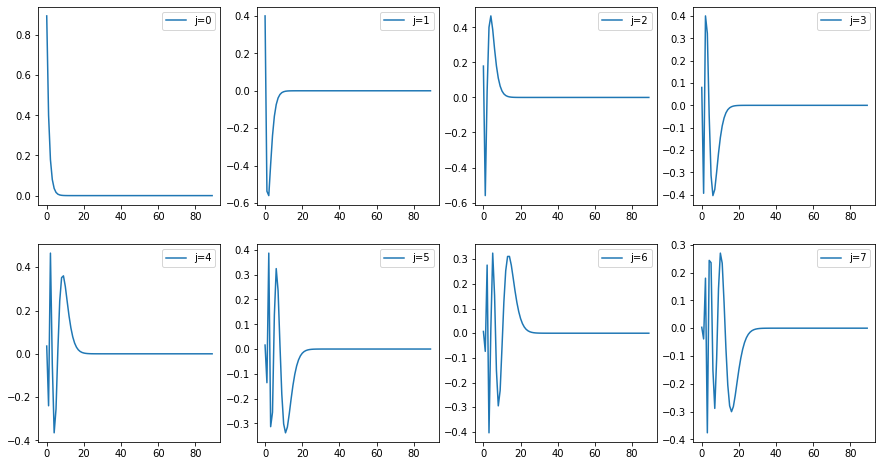

In [24]:
fig, ax = plt.subplots(2,4, figsize=(15, 8))
N=np.arange(W_n)

for j, axs in zip(range(J), ax.ravel()):
    p = []
    for n in range(W_n):
        p.append(phi_j(n,j, alpha))
    axs.plot(N,p, label=f'j={j}')
    axs.legend()

#### Calculating Laguerre filter output using laguerre polynomials and RR interval at time t=2 in the given window (w_n)

In [25]:
l_j(J,2, RR_clean, W_n, alpha)

array([ 1.55007381, -1.58536475,  1.75513049, -1.53011255,  1.68692422,
       -1.52592435,  1.61646638, -1.5607772 ,  1.6309304 ])

#### Laguerre filter output at all time points

In [26]:
lagj_t = lagl_j(J, RR_clean, W_n, alpha)

#### Convert the laguerre filter output matrix into dataframe

In [27]:
G = [f'l{j}'  for j in range(J+1)]
lag_df = pd.DataFrame(lagj_t, columns=G)
lag_df['RR'] = RR_clean['RR']


In [28]:
lag_df.shape

(3478, 10)

In [29]:
lag_df.head()

,l0,l1,l2,l3,l4,l5,l6,l7,l8,RR
0,1.538920,-1.565157,1.611326,-1.589008,1.614329,-1.576927,1.607169,-1.592099,1.584823,0.988
1,1.554031,-1.543896,1.595313,-1.608506,1.591612,-1.607762,1.576662,-1.614073,1.579018,1.008
2,1.535746,-1.557676,1.560727,-1.616680,1.597295,-1.596293,1.598983,-1.583411,1.612109,0.944
3,1.566923,-1.531610,1.570698,-1.581291,1.623837,-1.584977,1.602557,-1.590420,1.593110,0.984
4,1.591599,-1.540095,1.545296,-1.586795,1.597857,-1.618077,1.578036,-1.608095,1.583719,0.984


In [30]:
lag_df.iloc[:,0]

0       1.538920
1       1.554031
2       1.535746
3       1.566923
4       1.591599
          ...   
3473    1.628585
3474    1.640641
3475    1.663921
3476    1.634978
3477    1.707899
Name: l0, Length: 3478, dtype: float64

#### Visualize the laguerre filter output

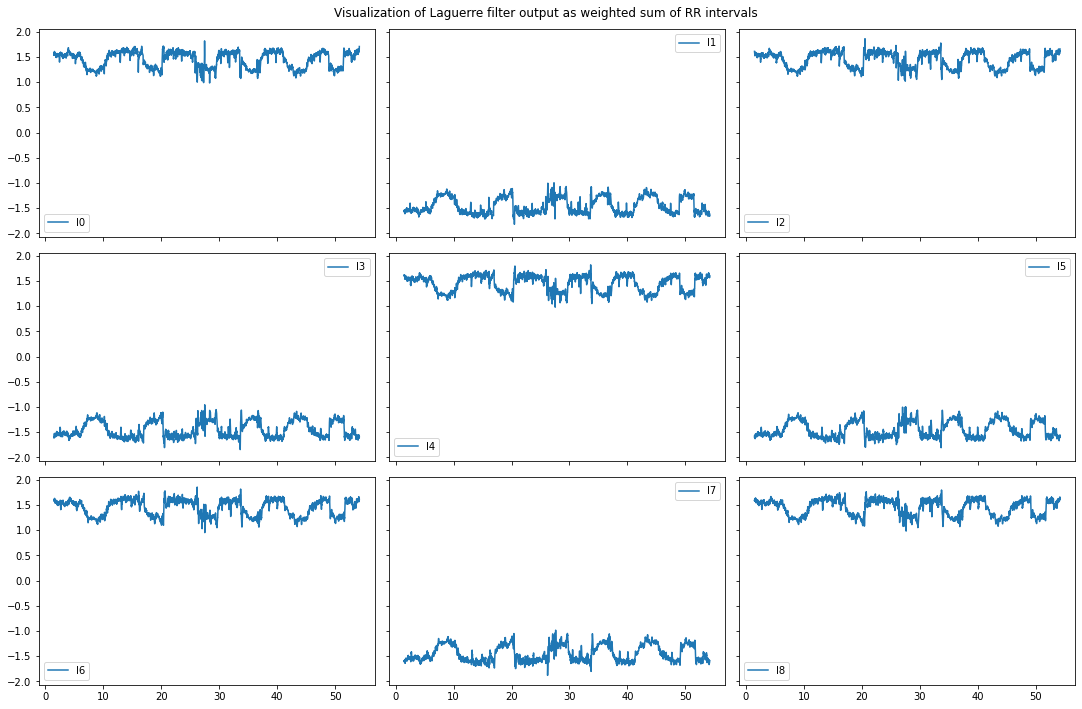

In [32]:
fig, ax = plt.subplots(3,3, figsize=(15,10), sharey=True, sharex=True)

for j, axs in zip(range(0, J+1), ax.ravel()):
    axs.plot(RR_clean['beats'][W_n-1:]/60, lag_df.iloc[:,j], label= f'l{j}')
    axs.legend()
    
fig.suptitle("Visualization of Laguerre filter output as weighted sum of RR intervals")
fig.tight_layout()

#### Add a column of constant 

In [33]:
lag_df.insert(0,'const', 1 )
#lag_df

In [34]:
lag_df.iloc[1,:-1]

const    1.000000
l0       1.554031
l1      -1.543896
l2       1.595313
l3      -1.608506
l4       1.591612
l5      -1.607762
l6       1.576662
l7      -1.614073
l8       1.579018
Name: 1, dtype: float64

## Recursive Least Square Method implementation

In [35]:
# Initialization
theta = np.zeros((J+1,1))
phi = np.empty((1,J+1))
P = np.eye((J+1))*100

In [36]:
np.expand_dims(phi[0], axis=0).shape


(1, 9)

In [37]:
np.expand_dims(lag_df.iloc[1,:-1], axis=1).shape

(10, 1)

In [38]:
x = np.array([lag_df.iloc[i,:-1] for i in range(len(lag_df))])
x.shape

(3478, 10)

In [39]:
x[0]

array([ 1.        ,  1.53891996, -1.56515719,  1.61132552, -1.58900784,
        1.61432933, -1.57692723,  1.6071694 , -1.59209914,  1.58482318])

In [40]:
y = lag_df['RR']
y.shape

(3478,)

### Calculate the indices for widow size 90 and forgetting factor .98

In [41]:
# Implementing RLS algorithm
class RecursiveLeastSquares:
    def __init__(self, num_parameters, forgetting_factor):
        self.num_parameters = num_parameters
        self.forgetting_factor = forgetting_factor
        self.theta = np.zeros((num_parameters,1))
        self.P = np.eye(num_parameters)  # Initial covariance matrix

    def update_params(self, x, y):
        x = np.reshape(x, (self.num_parameters, 1))  # Reshape input vector
        y_hat = np.dot(np.transpose(self.theta), x)  # Predicted output


        # Calculate the gain matrix
        k = np.dot(self.P, x) / (self.forgetting_factor + np.dot(np.dot(np.transpose(x), self.P), x))

        # Update the estimated parameter 
        self.theta = self.theta + np.dot(k, (y - y_hat))

        # Update the covariance matrix
        self.P = (1 / self.forgetting_factor) * (self.P - np.dot(np.dot(k, np.transpose(x)), self.P))

    def get_parameters(self):
        return self.theta

In [42]:
# Create an instance of the RLS estimator
rls_estimator = RecursiveLeastSquares(num_parameters, forgetting_factor)
params_w_100 = []

# Perform recursive parameter estimation
for i in range(W_n, len(lag_df)):
    x_w_n = np.array(x[i-W_n:i])
    y_w_n = np.array(y[i-W_n:i])
    [rls_estimator.update_params(x_w_n[j], y_w_n[j]) for j in range(W_n)]
    params_w_100.append(rls_estimator.get_parameters())
    #print(rls_estimator.get_parameters()) #Get the estimated parameters

In [43]:
#reduce the dimension of list elements
params_w_100=np.squeeze(params_w_100)
params_w_100

array([[ 0.08665036,  0.08814757, -0.11637641, ...,  0.0639806 ,
        -0.00204707,  0.08405374],
       [ 0.28985704,  0.10537281, -0.15497474, ...,  0.11891584,
         0.1550124 ,  0.12609188],
       [ 0.78093125,  0.08646476, -0.12048872, ...,  0.16309218,
         0.28754814,  0.12141643],
       ...,
       [ 0.88706077,  0.47122736,  0.07509364, ..., -0.07207976,
         0.05002354, -0.05560313],
       [ 0.88280953,  0.47195718,  0.09032895, ..., -0.05813745,
         0.03674486, -0.06497502],
       [ 0.86623546,  0.45002036,  0.06234834, ..., -0.0693622 ,
         0.01194795, -0.0662445 ]])

In [44]:
print(len(params_w_100))
print(params_w_100.shape)

3388
(3388, 10)


#### Calculate the indices

In [45]:
SAI = coeff_S[0] + np.sum(coeff_S[1:]*params_w_100[:,1:3], axis=1)
PAI = coeff_P[0] + np.sum(coeff_P[1:7]*params_w_100[:,4:], axis=1)

In [46]:
len(SAI)

3388

In [47]:
peaks,  props= find_peaks(np.round(angle_df.Angle), width=3, height=[73,76], plateau_size = 3)
props

{'plateau_sizes': array([   58, 46864, 49757, 43501, 37002], dtype=int64),
 'left_edges': array([100072, 100133, 250835, 624706, 732443], dtype=int64),
 'right_edges': array([100129, 146996, 300591, 668206, 769444], dtype=int64),
 'peak_heights': array([74., 74., 75., 74., 75.]),
 'prominences': array([74., 74., 75., 74., 75.]),
 'left_bases': array([ 87529,  87529, 250300, 612056, 731983], dtype=int64),
 'right_bases': array([159382, 159382, 301187, 680639, 770021], dtype=int64),
 'widths': array([57691., 57691., 50314., 54405., 37469.]),
 'width_heights': array([37. , 37. , 37.5, 37. , 37.5]),
 'left_ips': array([ 94643. ,  94643. , 250488.5, 619188. , 732169.5]),
 'right_ips': array([152334. , 152334. , 300802.5, 673593. , 769638.5])}

In [48]:
stats.pearsonr(SAI, RR_clean['angle_peaks'][2*90-1:])


(-0.1449991519909289, 2.2203859746264674e-17)

In [49]:
stats.pearsonr(PAI, RR_clean['angle_peaks'][2*90-1:])

(-0.20986607781137345, 4.942310722897543e-35)

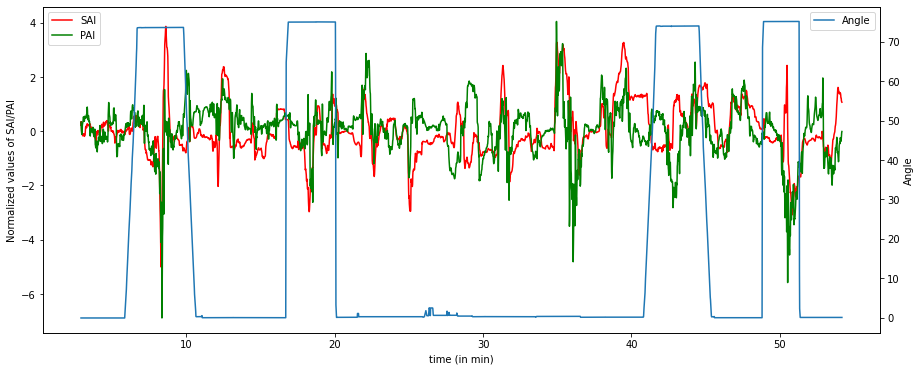

In [50]:
# Instantiate a second axes that shares the same x-axis
fig, ax1 = plt.subplots(1,1, figsize=(15, 6))
ax2 = ax1.twinx()

ax1.plot(RR_clean['beats'][2*W_n-1:]/60, normalize(SAI), color='red', label='SAI')
ax1.plot(RR_clean['beats'][2*W_n-1:]/60, normalize(PAI), color='green', label='PAI')
ax2.plot(RR_clean['beats'][2*W_n-1:]/60, RR_clean['angle_peaks'][2*W_n-1:], label='angle')
ax1.set_xlabel("time (in min)")
ax2.set_ylabel("Angle")
ax1.set_ylabel("Normalized values of SAI/PAI")
ax1.legend(['SAI', 'PAI'], loc='upper left')
ax2.legend(['Angle'])

### RLS without moving window

In [51]:
# Create an instance of the RLS estimator
rls_estimator = RecursiveLeastSquares(num_parameters, forgetting_factor)
params = []

# Perform recursive parameter estimation
for i in range(len(lag_df+1)):
    rls_estimator.update_params(x[i], y[i])
    params.append(rls_estimator.get_parameters())
    #print(rls_estimator.get_parameters()) #Get the estimated parameters

In [57]:
params=np.squeeze(params)
params.shape

(3478, 10)

In [65]:
params[:,1:3]

array([[ 0.06170293, -0.06275491],
       [ 0.06413666, -0.06407718],
       [ 0.06362635, -0.0632366 ],
       ...,
       [ 0.44157242,  0.13152292],
       [ 0.44626022,  0.13249593],
       [ 0.39320386,  0.07424727]])

In [66]:
params[:,4:]

array([[-0.0637112 ,  0.06472646, -0.06322683,  0.06443939, -0.06383514,
         0.06354341],
       [-0.06634673,  0.06606549, -0.06620382,  0.06552411, -0.06655254,
         0.06537721],
       [-0.06514612,  0.06540575, -0.06533202,  0.06457316, -0.06622277,
         0.06389733],
       ...,
       [ 0.11310266, -0.02963264, -0.0253208 , -0.0140963 , -0.00539446,
         0.15027866],
       [ 0.10880582, -0.04113489, -0.02798969, -0.00955323,  0.00889601,
         0.16350984],
       [ 0.10811763, -0.03202705, -0.05231872, -0.04387427, -0.03349858,
         0.13651851]])

In [60]:
SAI1 = coeff_S[0] + np.sum(coeff_S[1:]*params[:,1:3], axis=1)
PAI1 = coeff_P[0] + np.sum(coeff_P[1:7]*params[:, 4:], axis=1)

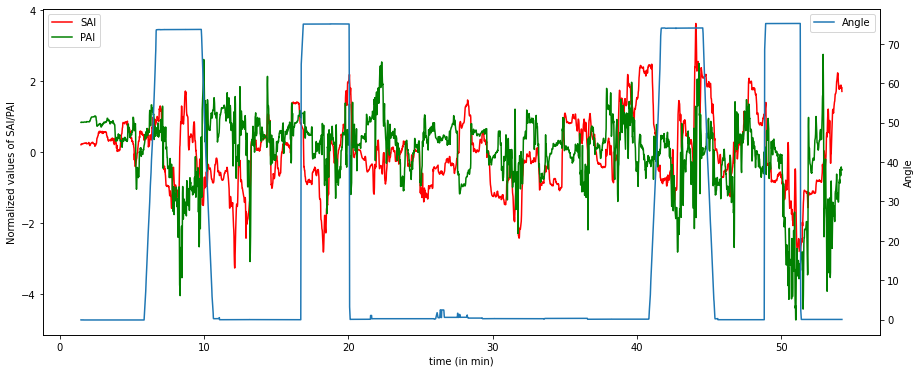

In [61]:
# Instantiate a second axes that shares the same x-axis
fig, ax1 = plt.subplots(1,1, figsize=(15, 6))
ax2 = ax1.twinx()

ax1.plot(RR_clean['beats'][W_n-1:]/60, normalize(SAI1), color='red', label='SAI')
ax1.plot(RR_clean['beats'][W_n-1:]/60, normalize(PAI1), color='green', label='PAI')
ax2.plot(RR_clean['beats'][W_n-1:]/60, RR_clean['angle_peaks'][W_n-1:], label='angle')
ax1.set_xlabel("time (in min)")
ax2.set_ylabel("Angle")
ax1.set_ylabel("Normalized values of SAI/PAI")
ax1.legend(['SAI', 'PAI'], loc='upper left')
ax2.legend(['Angle'])

In [63]:
stats.pearsonr(SAI1, RR_clean['angle_peaks'][W_n-1:])

(-0.09563498595393619, 1.5955346197063523e-08)

In [64]:
stats.pearsonr(PAI1, RR_clean['angle_peaks'][W_n-1:])

(-0.3057628241656922, 3.610822616922381e-76)